## JUMIA-PRODUCTS-RECOMMENDATION-AND-PRODUCT-REVIEW-SYSTEM

### Overview

The growth of e-commerce in Kenya has been exponential, with platforms like Jumia attracting large numbers of users. However, users frequently encounter challenges in locating relevant products due to expansive and sometimes disorganized product catalogs. Moreover, the limited use of recommendations and unreliable review systems further complicate the shopping experience, leading to reduced user satisfaction and lower conversion rates. To address these issues, we propose a recommendation and sentiment analysis system that leverages interaction history and user feedback. This system aims to provide more relevant recommendations and insights from customer sentiments, enabling Jumia to better serve its users and enhance its retail offerings.

### Problem Statement

The problem of finding relevant products on Jumia’s extensive catalog significantly affects customer satisfaction and conversion rates. Current limitations include:  

* Inadequate product recommendations based on user behavior, which leads to a lack of personalization.
* An unreliable rating and review system, leaving customers with limited insights into product quality.
* Limited retailer insights into customer sentiment, hindering their ability to refine offerings and optimize marketing strategies.
  
These issues reduce user satisfaction, decrease sales, and limit the potential for enhanced customer-retailer relationships on Jumia.

### Stakeholders

**Primary Users (Consumers)**: Customers who frequently shop on Jumia and need relevant recommendations to streamline their product search and improve purchase decisions.

**Retailers/Sellers**: Businesses and individual sellers on Jumia who seek insights into customer preferences and sentiment to better tailor their product offerings and marketing strategies.

**Jumia Management**: The platform administrators who aim to improve customer satisfaction, engagement, and conversion rates through improved site functionality.

### Objectives

* *Develop a Recommendation System*:

Create an intelligent recommendation engine that uses customer interaction history, preferences, and similar behavior patterns to provide relevant product recommendations.

* *Implement Sentiment Analysis*:

Extract sentiments from customer reviews to offer meaningful feedback, categorizing it as positive, negative, or neutral. This feedback will help refine recommendations and improve customer trust in the platform.

* *Enhance User Experience*:

Improve customer satisfaction by reducing the time and effort needed to find relevant products, potentially increasing conversion rates.

* *Provide Insightful Retailer Analytics*:

Equip sellers with sentiment analysis reports and recommendation patterns to refine product and marketing offerings based on customer preferences.

* *Support Kenyan E-commerce Growth*:

Contribute to the development of the e-commerce sector in Kenya by addressing key pain points in product discoverability and review reliability on Jumia.

### Expected Benefits

* **For Customers**: More personalized recommendations, improved trust through reliable sentiment analysis, and an overall enhanced shopping experience.

* **For Retailers**: Access to better customer insights and sentiment data, allowing them to optimize product listings, improve customer engagement, and refine marketing strategies.

* **For Jumia**: Increased user satisfaction and conversion rates, resulting in stronger brand loyalty and a more competitive edge in the Kenyan e-commerce market.

### Data Understanding

We scraped data from [jumia](https://www.jumia.co.ke/) which is an online shop with more than 15 categories of products but decided to only have 15 categories

### Exploratory Data Ananlysis

Importing relevant libraries

In [121]:
#import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE 
from scipy import stats as stats
from imblearn.pipeline import Pipeline as imbpipe
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,\
roc_curve,roc_auc_score,classification_report, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import random
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

### Data Understanding

Loading the scraped dataset

In [2]:
# Load the data into a dataframe and read the first five rows
df = pd.read_csv('./Data/combined_dta.csv', encoding='ISO-8859-1')

df.head()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,link,link-href,see_all,see_all-href,review_title,review,ratings,user_name,date,see_all_link,see_all_link-href,Category
0,1730407108-1,https://www.jumia.co.ke/computer-accessories/,Black Friday dealLaptop Skin Wrap Vinyl from 1...,https://www.jumia.co.ke/generic-laptop-skin-wr...,Laptop Skin Wrap Vinyl from 12-17.0 inches Lap...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,KSh 699 - KSh 797,NaN,NaN,https://www.jumia.co.ke/computer-accessories/?...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Computing
1,1730407112-2,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,"KSh 3,325",NaN,NaN,https://www.jumia.co.ke/computer-accessories/?...,See All,https://www.jumia.co.ke/catalog/productratings...,OKAY,"Working, feels cheap",3 out of 5,by WILFRED,28/04/2022,NaN,NaN,Computing
2,1730407112-3,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,"KSh 3,325",NaN,NaN,https://www.jumia.co.ke/computer-accessories/?...,See All,https://www.jumia.co.ke/catalog/productratings...,okay,A bit big for a regular laptop bag... The fanc...,4 out of 5,by Michael,8/7/2021,NaN,NaN,Computing
3,1730407114-4,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealLexar 2.5"" SATA 256GB Laptop ...",https://www.jumia.co.ke/lexar-2.5-sata-256gb-l...,"Lexar 2.5"" SATA 256GB Laptop SSD",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,"KSh 3,799",Lexar,NaN,https://www.jumia.co.ke/computer-accessories/?...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Computing
4,1730407116-5,https://www.jumia.co.ke/computer-accessories/,"WD External Portable Hard Drive-2TBKSh 15,000",https://www.jumia.co.ke/wd-external-portable-h...,WD External Portable Hard Drive-2TB,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,"KSh 15,000",WD,NaN,https://www.jumia.co.ke/computer-accessories/?...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Computing


In [3]:
# Get the number of rows and columns
print(df.shape, '\n')

print(f'The scraped data have {df.shape[0]} rows and {df.shape[1]} columns')

(60464, 20) 

The scraped data have 60464 rows and 20 columns


To arrive at this number of rows, we ensured that we scraped as much data as possible both from the product categories and sub-categories despite being blocked from sourcing most of it but we believe that this dataset will be helpful in achieving our objectives

In [4]:
# Statistical summary

df.describe()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,link,link-href,see_all,see_all-href,review_title,review,ratings,user_name,date,see_all_link,see_all_link-href,Category
count,60464,60464,60464,60464,60464,60431,60431,39584,28043,35931,40431,40432,37705,40208,37717,37717,37717,51,51,60464
unique,60226,216,25444,26683,22874,26650,7994,1690,4,622,3,7817,13071,25610,6,9261,1935,1,1,14
top,?web-scraper-order,https://www.jumia.co.ke/mobile-phones/,Black Friday dealOut of StockOfficial StoreHis...,https://www.jumia.co.ke/hisense-ax-3100g-3.1ch...,Hisense AX-3100G 3.1ch Dolby Atmos Home Cinema...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,KSh 999,Fashion,2,https://www.jumia.co.ke/mobile-phones/?page=2#...,See All,https://www.jumia.co.ke/catalog/productratings...,I like it,Good,5 out of 5,by Brian,11/10/2024,see_all_link,see_all_link-href,Fashion
freq,51,1448,192,192,192,192,528,10798,15101,488,37858,192,3389,309,21726,366,470,51,51,11684


In [5]:
# Let's look at the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60464 entries, 0 to 60463
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   web-scraper-order      60464 non-null  object
 1   web-scraper-start-url  60464 non-null  object
 2   product                60464 non-null  object
 3   product-href           60464 non-null  object
 4   product_name           60464 non-null  object
 5   image                  60431 non-null  object
 6   price                  60431 non-null  object
 7   brand                  39584 non-null  object
 8   link                   28043 non-null  object
 9   link-href              35931 non-null  object
 10  see_all                40431 non-null  object
 11  see_all-href           40432 non-null  object
 12  review_title           37705 non-null  object
 13  review                 40208 non-null  object
 14  ratings                37717 non-null  object
 15  user_name          

In [6]:
print(f'We have {df.shape[1]} columns in our dataset', '\n')

print('The columns are:')

df.columns

We have 20 columns in our dataset 

The columns are:


Index(['web-scraper-order', 'web-scraper-start-url', 'product', 'product-href',
       'product_name', 'image', 'price', 'brand', 'link', 'link-href',
       'see_all', 'see_all-href', 'review_title', 'review', 'ratings',
       'user_name', 'date', 'see_all_link', 'see_all_link-href', 'Category'],
      dtype='object')

To have better understanding of what each column entails and what they mean, have a look at the `column_description.txt` file in the `Data` folder

### Data Cleaning

In [7]:
# Checks for row duplicates
df.duplicated().sum()

49

In [8]:
# Remove row duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [9]:
print(f'After dropping the 53 rows with duplicates, we now remaining with {df.shape[0]} rows and {df.shape[1]} columns')

After dropping the 53 rows with duplicates, we now remaining with 60415 rows and 20 columns


In [10]:
# Function to calculate the percentage of null values in every column

def null_percentages(df):
    
    # Calculate the number of missing values and their percentage
    null_values = df.isnull().sum()
    null_percentage = (null_values / df.shape[0]) * 100
    
    # Create a DataFrame with the results
    missing_data = pd.DataFrame({'Null Values': null_values, 'Percentage': null_percentage})

    # Filter out columns with no missing values and sort by 'Missing Values'
    missing_data = missing_data[missing_data['Null Values'] > 0].sort_values(by='Null Values', ascending=False)

    return missing_data

In [11]:
null_percentages(df)

,Null Values,Percentage
see_all_link,60413,99.996690
see_all_link-href,60413,99.996690
link,32421,53.663825
link-href,24533,40.607465
review_title,22759,37.671108
ratings,22747,37.651246
user_name,22747,37.651246
date,22747,37.651246
brand,20880,34.560953
review,20256,33.528097


We have lots of columns with over **35%** null values and so, we are going to of how to deal with the null values and at the same time maintain as much data as possible  

Let's plot a heat map for the missing values

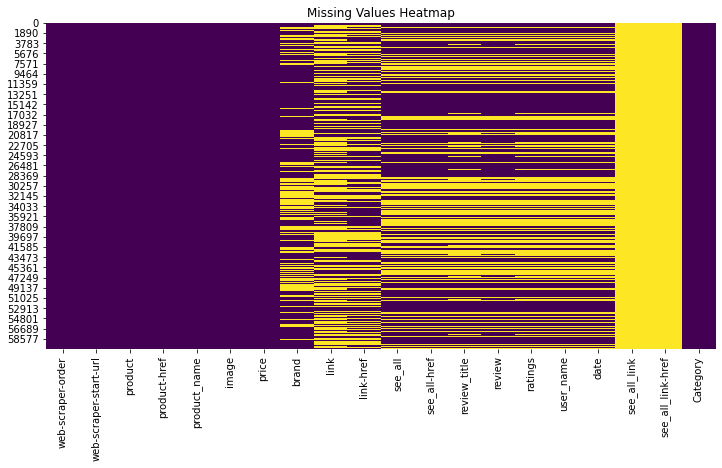

In [12]:
# Plot missing values as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show();

Notable Columns with Missing Data:

`review_title`  
`link-href`   
`user_rating`   
Several columns related to scraping and product information

*Data Quality Implications*:

This visualization helps identify:

* Which columns need data cleaning
* Patterns of missing data that might indicate scraping issues
* Columns that might need to be dropped or imputed
* Potential systematic issues in data collection

In [13]:
df.drop(['see_all_link-href', 'see_all_link', 'see_all-href', 'see_all', 'link-href', 'link'], axis=1, inplace=True,)
df.shape

(60415, 14)

In [14]:
df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'product', 'product-href',
       'product_name', 'image', 'price', 'brand', 'review_title', 'review',
       'ratings', 'user_name', 'date', 'Category'],
      dtype='object')

We are now remaining with 14 columns. 

Since we have got further information that we need from other columns, we going to extract **ratings** from `ratings` column, **sub_category** from `web-scraper-start-url` column, **overall_ratings** from `product` column and **rating_count** from `product` column

In [15]:
# Extract ratings, sub_category, overall_ratings, date, month, year and ratings_count

df['ratings'] = df['ratings'].str.extract(r'(\d+)').astype(float)

df['sub_category'] = df['web-scraper-start-url'].str.extract(r'\.ke/([^/]+)/')

df['overall_ratings'] = df['product'].str.extract(r'(\d+(\.\d+)?) out of 5')[0]

df['ratings_count'] = df['product'].str.extract(r'(\d+) out of 5\((\d+)\)')[1].astype(float)

In [16]:
# Stripping 'by' from user_name

df['user_name'] = df['user_name'].str.lstrip('by')

In [17]:
# Function to remove the currency and calculate the average of the price range

def convert_price(price):
    # Remove non-numeric characters (i.e.currency symbols)
    cleaned_price = re.sub(r"[^\d.-]", "", str(price))
    
    # Handle ranges
    if '-' in cleaned_price:
        try:
            low, high = map(float, cleaned_price.split('-'))
            return (low + high) / 2
        except ValueError:
            return None  # Return None if conversion fails
    else:
        try:
            return float(cleaned_price)  # Convert single prices to float
        except ValueError:
            return None

In [18]:
# Apply the conversion function to the price column

df['price'] = df['price'].apply(convert_price)

In [19]:
# Show the first 5 rows of the DataFrame

df.head()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,review_title,review,ratings,user_name,date,Category,sub_category,overall_ratings,ratings_count
0,1730407108-1,https://www.jumia.co.ke/computer-accessories/,Black Friday dealLaptop Skin Wrap Vinyl from 1...,https://www.jumia.co.ke/generic-laptop-skin-wr...,Laptop Skin Wrap Vinyl from 12-17.0 inches Lap...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,748.0,NaN,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN
1,1730407112-2,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,NaN,OKAY,"Working, feels cheap",3.0,WILFRED,28/04/2022,Computing,computer-accessories,4.1,7.0
2,1730407112-3,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,NaN,okay,A bit big for a regular laptop bag... The fanc...,4.0,Michael,8/7/2021,Computing,computer-accessories,4.1,7.0
3,1730407114-4,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealLexar 2.5"" SATA 256GB Laptop ...",https://www.jumia.co.ke/lexar-2.5-sata-256gb-l...,"Lexar 2.5"" SATA 256GB Laptop SSD",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3799.0,Lexar,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN
4,1730407116-5,https://www.jumia.co.ke/computer-accessories/,"WD External Portable Hard Drive-2TBKSh 15,000",https://www.jumia.co.ke/wd-external-portable-h...,WD External Portable Hard Drive-2TB,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,15000.0,WD,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN


In [20]:
print(f'We have {df.shape[0]} rows and {df.shape[1]} columns after extraction and addition of new columns')

We have 60415 rows and 17 columns after extraction and addition of new columns


We now going to remove columns that are no longer useful

In [21]:
df.drop(['web-scraper-start-url', 'product', 'product-href', 'date'], axis=1, inplace=True)

In [22]:
df.head()

,web-scraper-order,product_name,image,price,brand,review_title,review,ratings,user_name,Category,sub_category,overall_ratings,ratings_count
0,1730407108-1,Laptop Skin Wrap Vinyl from 12-17.0 inches Lap...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,748.0,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN
1,1730407112-2,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,NaN,OKAY,"Working, feels cheap",3.0,WILFRED,Computing,computer-accessories,4.1,7.0
2,1730407112-3,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,NaN,okay,A bit big for a regular laptop bag... The fanc...,4.0,Michael,Computing,computer-accessories,4.1,7.0
3,1730407114-4,"Lexar 2.5"" SATA 256GB Laptop SSD",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3799.0,Lexar,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN
4,1730407116-5,WD External Portable Hard Drive-2TB,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,15000.0,WD,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN


In [23]:
# Check for null values and their percentage

null_percentages(df)

,Null Values,Percentage
review_title,22759,37.671108
ratings,22749,37.654556
user_name,22747,37.651246
brand,20880,34.560953
overall_ratings,20583,34.069354
ratings_count,20583,34.069354
review,20256,33.528097
price,35,0.057933
image,33,0.054622
sub_category,2,0.003310


As per the above output, `ratings`, `user_name` and `review_title` which have over **35%** missing values  

Let's have a look at the statistical summary for the numerical columns

In [24]:
df.describe()

,price,ratings,ratings_count
count,6.038000e+04,37666.000000,39832.000000
mean,5.253730e+03,4.056762,90.309148
std,1.765041e+04,1.358256,281.202628
min,3.000000e+01,1.000000,1.000000
25%,7.248750e+02,3.000000,12.000000
50%,1.390000e+03,5.000000,31.000000
75%,3.849250e+03,5.000000,71.000000
max,1.370668e+06,5.000000,5225.000000


#### Imputation

In [25]:
# Impute less critical columns

df['brand'].fillna('Unknown', inplace=True)

df['review_title'].fillna('No Title', inplace=True)

df['user_name'].fillna('No name', inplace=True)

df['ratings'].fillna(0, inplace=True)

# df['review'].fillna('No review', inplace=True)

# df['overall_ratings'].fillna(0, inplace=True)

df['ratings_count'].fillna(0, inplace=True)

In [26]:
# Drop the remaining negligible null values

df = df.dropna()

In [27]:
null_percentages(df)

,Null Values,Percentage


In [28]:
df.shape

(39598, 13)

### Exploratory Data Analysis

#### *Category Distribution*

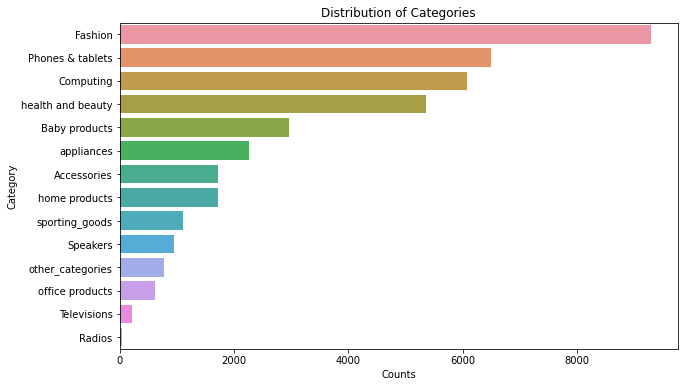

In [29]:
# Categorical column
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', 
              data=df,
              order=df['Category'].value_counts().index)
plt.title('Distribution of Categories')
plt.xlabel('Counts')
plt.ylabel('Category')
plt.show();

**Interpretation**

- The top few categories have significantly more products compared to those at the bottom, suggesting that certain categories (like `Fashion` and `Phone & tablets`) are highly populated in your dataset.  
- There’s a clear drop-off in frequency as you move down the list, which could indicate that some categories are more popular or that more products have been uploaded for those categories in the e-commerce catalog.

**Insights**

* *Customer Interest*: The top categories could reflect higher customer interest or demand, as vendors may upload more products in these areas.

* *Inventory Planning*: Retailers might focus more on stocking and promoting items in the most frequent categories.
* *Recommendation System Focus*: A recommendation system might prioritize building recommendations for these popular categories since they are likely to have more diverse options.

#### *Prices Distribution*

In [30]:
# Distribution Analysis
def plot_distribution(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=20)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show();

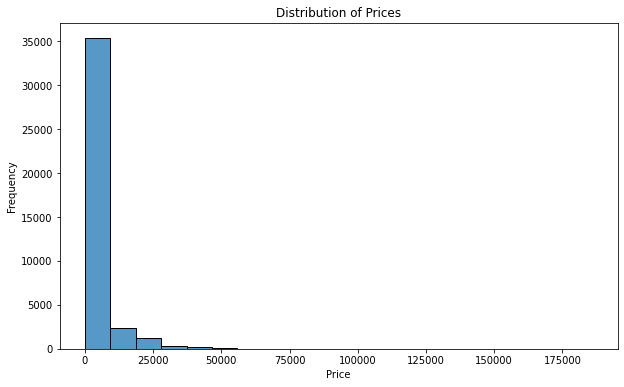

In [31]:
plot_distribution(df['price'], 'Distribution of Prices', 'Price', 'Frequency')

**Interpretation and Possible Implications**:

* *Imbalanced Dataset*: If you’re building a recommendation or classification system, this imbalance could bias the system towards the dominant category, potentially affecting its effectiveness across less-represented categories.

* *Customer Demand or Inventory Bias*: This could indicate a high customer demand for the dominant category, or it could reflect an inventory or data collection bias where most of the available products fall under this single category.

This kind of skewed distribution is common in datasets where one category or product type is significantly more popular or frequently added than others. 

In [32]:
# Since price is positively skewed, 

# Calculate IQR to detect outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[df['price'] > threshold]

print("Number of outliers:", len(outliers))
print(outliers[['product_name', 'price']].sort_values(by='price', ascending=False))

Number of outliers: 6206
                                            product_name     price
42858  LG 75UP7760 75" UHD 4K HDR WebOS Smart AI Thin...  186000.0
50080  Ramtons RF/265 - 527L Side By Side LED Fridge ...  149300.0
50079  Ramtons RF/265 - 527L Side By Side LED Fridge ...  149300.0
35870  Sony PS5 Playstation 5 Console Standard Editio...  114899.0
35871  Sony PS5 Playstation 5 Console Standard Editio...  114899.0
...                                                  ...       ...
41147  Vitron V527 - 2.1 CH Multimedia Speaker, BT/US...    4999.0
41146  Vitron V527 - 2.1 CH Multimedia Speaker, BT/US...    4999.0
17859                   Fashion African Wear  Mens Suit.    4999.0
17860                   Fashion African Wear  Mens Suit.    4999.0
41143  Vitron V527 - 2.1 CH Multimedia Speaker, BT/US...    4999.0

[6206 rows x 2 columns]


#### *Top 10 Sub Categories*

In [33]:
# Analyze the distribution of items across different subcategories

subcategory_counts = df['sub_category'].value_counts()

subcategory_counts

sub_category
mobile-accessories                        1806
mobile-phones                             1382
smartphones                               1099
computer-accessories                       838
audio-video-accessories                    806
                                          ... 
sports-nutrition-testosterone-boosters       2
compact-radios-stereos-boomboxes             2
skin-care-sets-kits                          1
baby-nursery-mattresses                      1
motorcycle-powersports                       1
Name: count, Length: 204, dtype: int64

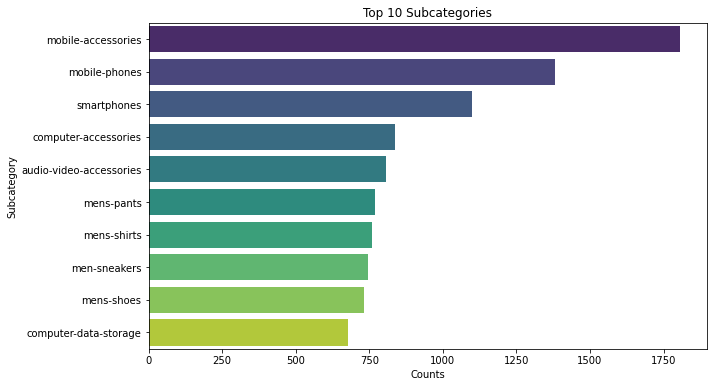

In [34]:
# Get the top 10 subcategories in descending order
top_10_subcategories = subcategory_counts.head(10)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_subcategories.values, y=top_10_subcategories.index, palette='viridis')
plt.title('Top 10 Subcategories')
plt.xlabel('Counts')
plt.ylabel('Subcategory')
plt.show();

**Potential Insights**

* *Customer Interest or Inventory Focus*: the top subcategories likely represent popular product types, high customer demand, or a focus on certain items.

#### *Bottom 10 Sub Categories*

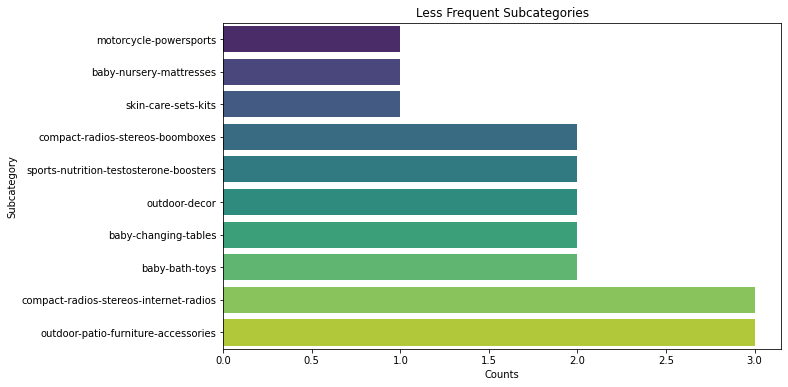

In [35]:
# Get the top 10 subcategories in descending order and then reverse them for ascending order
bottom_10_subcategories = subcategory_counts.tail(10).iloc[::-1]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=bottom_10_subcategories.values, y=bottom_10_subcategories.index, palette='viridis')
plt.title('Less Frequent Subcategories')
plt.xlabel('Counts')
plt.ylabel('Subcategory')
plt.show();

The above plot shows less frequent sub-categories potentially indicating lower popularity or inventory for these items.

#### *Users*

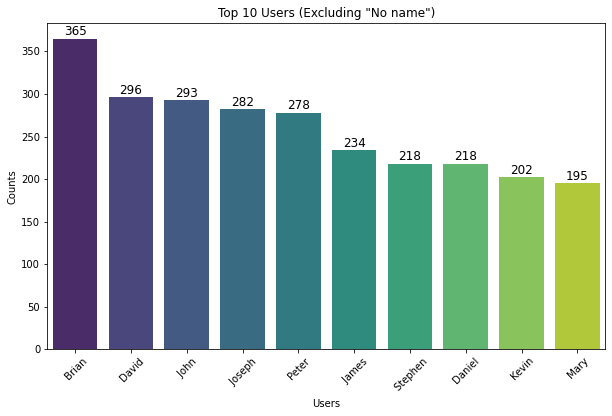

In [36]:
# Filter out 'No name' entries from the user_name column
filtered_users = df[df['user_name'] != 'No name']

# Get the top 10 users by count
top_10_users = filtered_users['user_name'].value_counts().head(10)
    
# Plot the vertical bar chart for the top 10 users
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_users.index, y=top_10_users.values, palette='viridis')
# Annotate the bars with the count values
for i, value in enumerate(top_10_users.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=12)
plt.title('Top 10 Users (Excluding "No name")')
plt.xlabel('Users')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show();

**User Engagement**:

This distribution suggests that a few users are significantly more engaged than others in providing feedback. These top users are repeat customers or highly active reviewers who frequently purchase and leave feedback on products.

#### *Ratings*

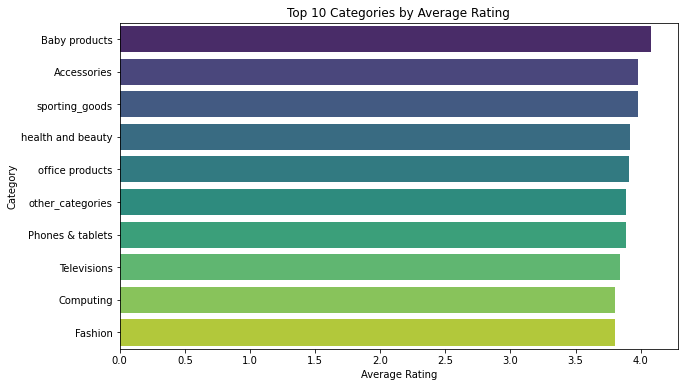

In [37]:
# Calculate the average rating for each category
category_average_ratings = df.groupby('Category')['ratings'].mean()

# Sort the categories by average rating and get the top 10
ratings = category_average_ratings.sort_values(ascending=False).head(10)
# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=ratings.values, y=ratings.index, palette='viridis')
plt.title('Top 10 Categories by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Category')
plt.show();

**Highest-Rated Category**: The first bar, `Baby products` followed closed by `Accessories`, represents the categories with the highest average rating. This suggests that customers are most satisfied with products in these categories, which might indicate superior product quality or customer satisfaction in those categories.

#### *Rating Count*

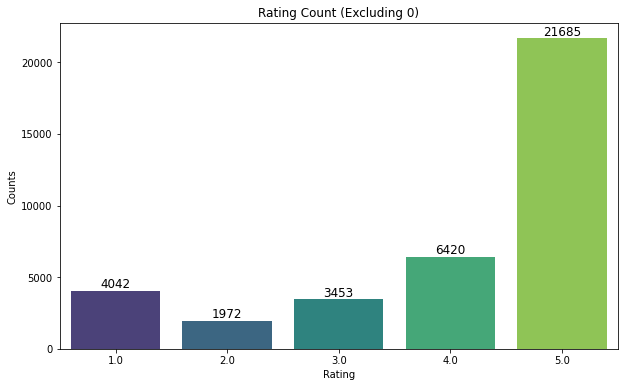

In [38]:
# Filter out ratings of 0
filtered_ratings = df[df['ratings'] > 0]['ratings'].value_counts().sort_index()

# Plot vertical bar chart for filtered ratings count
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=filtered_ratings.index, y=filtered_ratings.values, palette='viridis')

# Annotate the bars with the count values
for i, value in enumerate(filtered_ratings.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=12)

plt.title('Rating Count (Excluding 0)')
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.show();

From the above plot, we can see that **5** is the most rating used by the website users followed by **4** which is a clear indication majority of the products are satisfying and pleasing to the buyers.

#### *Price vs Ratings*

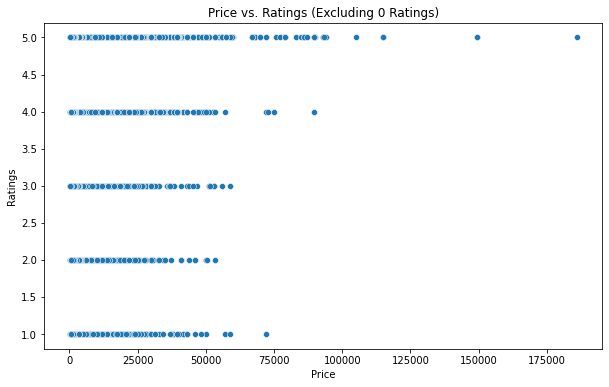

In [39]:
# Filter out rows where ratings are 0
filtered_df = df[df['ratings'] > 0]

# Scatter plot of price vs. ratings (excluding 0 ratings)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtered_df['price'], y=filtered_df['ratings'])
plt.title('Price vs. Ratings (Excluding 0 Ratings)')
plt.xlabel('Price')
plt.ylabel('Ratings')
plt.show();

This scatter plot shows that:

* Products have a broad range of prices for each rating level.
* Higher ratings (3 to 5) are more frequent than lower ratings (1 or 2).
* There’s no direct correlation between price and rating based on this visual.

#### *Product branding*

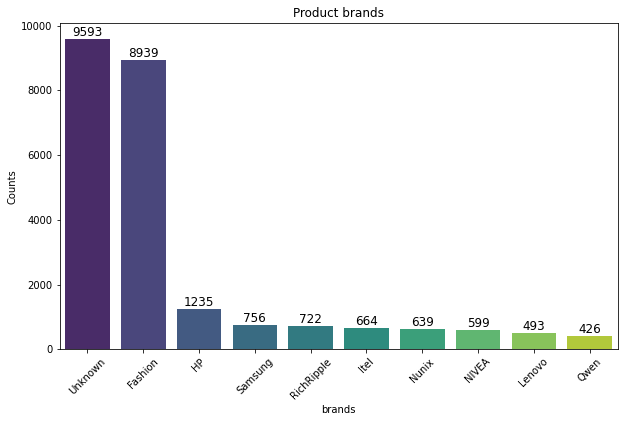

In [40]:
# Get the product branding by count
product_brands = df['brand'].value_counts().head(10)
    
# Plot the vertical bar chart for the product branding
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=product_brands.index, y=product_brands.values, palette='viridis')
# Annotate the bars with the count values
for i, value in enumerate(product_brands.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=12)
plt.title('Product brands')
plt.xlabel('brands')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show();

From the above output, it is evident that majority of product's brands are not indicated in the Jumia website but for best analytical visualization we collectively gave the product's brand placeholder `Uknown`. Most of the `Fashion` seems to be branded. There is a challenge in indicating the product's brand in the website that would help site users in knowing the product brands.

#### *Frequently Listed Products*

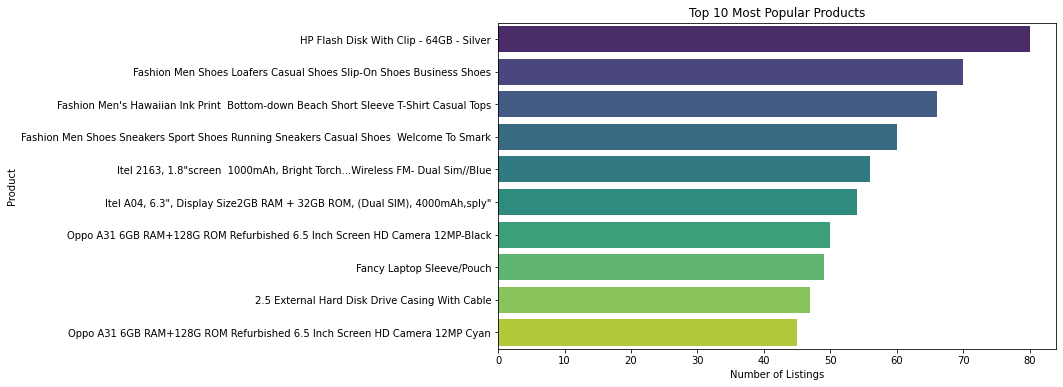

In [41]:
# Analyzing the most frequently listed products
plt.figure(figsize=(10, 6))
top_products = df['product_name'].value_counts().head(10)
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Most Popular Products')
plt.xlabel('Number of Listings')
plt.ylabel('Product')
plt.show();

**Insights**:

* Top Product: The product with the longest bar is the most popular, possibly indicating it is a bestseller or highly favored among customers.
* Less Popular Products: The products with shorter bars are less popular, which might indicate lower sales or reduced customer preference.

### Data Preprocessing

In [42]:
df.head()

,web-scraper-order,product_name,image,price,brand,review_title,review,ratings,user_name,Category,sub_category,overall_ratings,ratings_count
1,1730407112-2,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,Unknown,OKAY,"Working, feels cheap",3.0,WILFRED,Computing,computer-accessories,4.1,7.0
2,1730407112-3,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,Unknown,okay,A bit big for a regular laptop bag... The fanc...,4.0,Michael,Computing,computer-accessories,4.1,7.0
29,1730407173-30,Toshiba High Speed Micro SD Memory Card,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,803.0,Toshiba,good,genuine,4.0,your name,Computing,computer-accessories,4.7,3.0
30,1730407177-31,Lenovo Laptop Charger For Lenovo ThinkPad Yoga...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,4157.0,Lenovo,I like it,It worked out well,1.0,Bathsheba,Computing,computer-accessories,4,4.0
37,1730407197-38,"Safaricom, Airtel & Telkom -4G/3G Universal Modem",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,2600.0,Unknown,Works well,So far so good...,5.0,Ngarachu,Computing,computer-accessories,6003.7,86.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39598 entries, 1 to 60463
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   web-scraper-order  39598 non-null  object 
 1   product_name       39598 non-null  object 
 2   image              39598 non-null  object 
 3   price              39598 non-null  float64
 4   brand              39598 non-null  object 
 5   review_title       39598 non-null  object 
 6   review             39598 non-null  object 
 7   ratings            39598 non-null  float64
 8   user_name          39598 non-null  object 
 9   Category           39598 non-null  object 
 10  sub_category       39598 non-null  object 
 11  overall_ratings    39598 non-null  object 
 12  ratings_count      39598 non-null  float64
dtypes: float64(3), object(10)
memory usage: 4.2+ MB


In [44]:
df1 = df.copy()

df1.drop(['web-scraper-order', 'image', 'review_title', 'overall_ratings', 'ratings_count'], axis=1, inplace=True)

df1.head()

,product_name,price,brand,review,ratings,user_name,Category,sub_category
1,"9""-17"" Laptop Cooling Stand Pad",3325.0,Unknown,"Working, feels cheap",3.0,WILFRED,Computing,computer-accessories
2,"9""-17"" Laptop Cooling Stand Pad",3325.0,Unknown,A bit big for a regular laptop bag... The fanc...,4.0,Michael,Computing,computer-accessories
29,Toshiba High Speed Micro SD Memory Card,803.0,Toshiba,genuine,4.0,your name,Computing,computer-accessories
30,Lenovo Laptop Charger For Lenovo ThinkPad Yoga...,4157.0,Lenovo,It worked out well,1.0,Bathsheba,Computing,computer-accessories
37,"Safaricom, Airtel & Telkom -4G/3G Universal Modem",2600.0,Unknown,So far so good...,5.0,Ngarachu,Computing,computer-accessories


### Sentiment Analysis

In [45]:
def map_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

In [46]:
# Applying the function to the ratings column to create a new sentiment column
df1['sentiment'] = df1['ratings'].apply(map_sentiment)

#### *Sentiment Distribution*

In [47]:
# Checking the count of each sentiment category
sentiment_counts = df1['sentiment'].value_counts()

sentiment_counts

sentiment
Positive    28105
Negative     8040
Neutral      3453
Name: count, dtype: int64

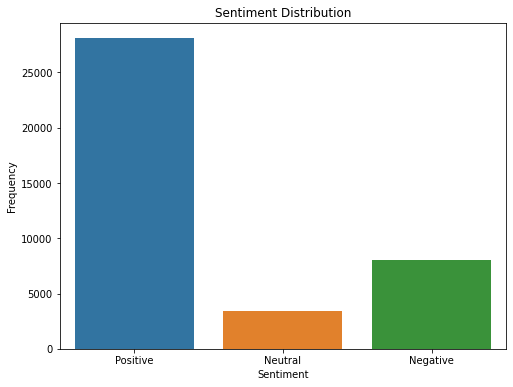

In [48]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df1, x='sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show();

In [49]:
# Grouping by Category to see sentiment counts per category
category_sentiment = df1.groupby('Category')['sentiment'].value_counts(normalize=True).unstack()
print(category_sentiment)

sentiment          Negative   Neutral  Positive
Category                                       
Accessories        0.173535  0.076611  0.749855
Baby products      0.151976  0.087470  0.760554
Computing          0.211488  0.070606  0.717907
Fashion            0.219785  0.096452  0.683763
Phones & tablets   0.192462  0.102000  0.705538
Radios             0.323529  0.058824  0.617647
Speakers           0.248941  0.088983  0.662076
Televisions        0.199052  0.052133  0.748815
appliances         0.219771  0.073257  0.706973
health and beauty  0.189260  0.075517  0.735223
home products      0.266744  0.099592  0.633663
office products    0.190865  0.083197  0.725938
other_categories   0.191026  0.094872  0.714103
sporting_goods     0.167568  0.098198  0.734234


#### *Sentiment by Category*

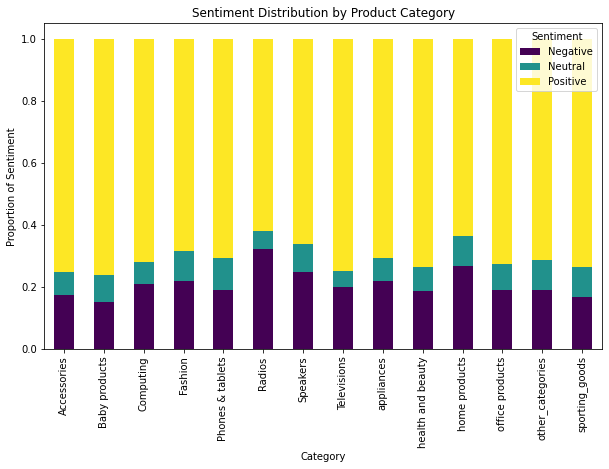

In [50]:
# Stacked bar chart for sentiment by category
category_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6), colormap="viridis")
plt.title("Sentiment Distribution by Product Category")
plt.xlabel("Category")
plt.ylabel("Proportion of Sentiment")
plt.legend(title="Sentiment")
plt.show();

In [51]:
df1.head()

,product_name,price,brand,review,ratings,user_name,Category,sub_category,sentiment
1,"9""-17"" Laptop Cooling Stand Pad",3325.0,Unknown,"Working, feels cheap",3.0,WILFRED,Computing,computer-accessories,Neutral
2,"9""-17"" Laptop Cooling Stand Pad",3325.0,Unknown,A bit big for a regular laptop bag... The fanc...,4.0,Michael,Computing,computer-accessories,Positive
29,Toshiba High Speed Micro SD Memory Card,803.0,Toshiba,genuine,4.0,your name,Computing,computer-accessories,Positive
30,Lenovo Laptop Charger For Lenovo ThinkPad Yoga...,4157.0,Lenovo,It worked out well,1.0,Bathsheba,Computing,computer-accessories,Negative
37,"Safaricom, Airtel & Telkom -4G/3G Universal Modem",2600.0,Unknown,So far so good...,5.0,Ngarachu,Computing,computer-accessories,Positive


In [52]:
df2 = df1[['review', 'sentiment']]

df2.head()

,review,sentiment
1,"Working, feels cheap",Neutral
2,A bit big for a regular laptop bag... The fanc...,Positive
29,genuine,Positive
30,It worked out well,Negative
37,So far so good...,Positive


In [53]:
review = df2['review']

In [54]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_review(review):
    # First, handle any non-string entries
    def convert_to_string(x):
        if pd.isna(x):  # Handle NaN values
            return ""
        return str(x)   # Convert everything else to string
    
    # Convert all entries to strings
    review_strings = review.apply(convert_to_string)
    
    # Convert to lowercase
    review_lower = review.str.lower()
    
    # Remove URLs
    review_no_urls = review_lower.apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))
    
    # Remove mentions (@username)
    review_no_mentions = review_no_urls.apply(lambda x: re.sub(r'@\w+', '', x))
    
    # Remove hashtags (#topic)
    review_no_hashtags = review_no_mentions.apply(lambda x: re.sub(r'#\w+', '', x))
    
    # Remove punctuation
    review_no_punct = review_no_hashtags.apply(lambda x: re.sub(r'[^\w\s]', '', x))
    
    # Remove numbers
    review_no_numbers = review_no_punct.apply(lambda x: re.sub(r'\d+', '', x))
    
    # Remove extra whitespace
    review_clean = review_no_numbers.apply(lambda x: ' '.join(x.split()))
    
    # Tokenization
    review_tokenized = review_clean.apply(lambda x: word_tokenize(x) if x.strip() else [])
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    review_no_stopwords = review_tokenized.apply(lambda x: [word for word in x if word not in stop_words])
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    review_lemmatized = review_no_stopwords.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    # Concatenate tokens back into sentences
    review_final = review_lemmatized.apply(lambda x: ' '.join(x))
    
    return review_final

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [55]:
cleaned_review = clean_review(review)

print("Original review:\n", review)
print("\nCleaned review:\n", cleaned_review)

Original review:
 1                                     Working, feels cheap
2        A bit big for a regular laptop bag... The fanc...
29                                                 genuine
30                                      It worked out well
37                                       So far so good...
                               ...                        
60452                                    Very good product
60454                                            It's good
60460                   Small but does the work perfectly.
60462    The smell is good but doesn't actually last on...
60463                              As expected,  very good
Name: review, Length: 39598, dtype: object

Cleaned review:
 1                                       working feel cheap
2        bit big regular laptop bag fancy blue light is...
29                                                 genuine
30                                             worked well
37                                  

In [56]:
# Add the cleaned_review series as a new column to df2
df2['cleaned_review'] = cleaned_review

df2.head()

,review,sentiment,cleaned_review
1,"Working, feels cheap",Neutral,working feel cheap
2,A bit big for a regular laptop bag... The fanc...,Positive,bit big regular laptop bag fancy blue light is...
29,genuine,Positive,genuine
30,It worked out well,Negative,worked well
37,So far so good...,Positive,far good


Dropping the uncleaned `review` column

In [57]:
df2.drop(columns='review', axis=1, inplace=True)

df2.head()

,sentiment,cleaned_review
1,Neutral,working feel cheap
2,Positive,bit big regular laptop bag fancy blue light is...
29,Positive,genuine
30,Negative,worked well
37,Positive,far good


Statistical summary

In [58]:
df2.describe()

,sentiment,cleaned_review
count,39598,39598
unique,3,21995
top,Positive,good
freq,28105,840


#### *WordCount for Positive Sentiments*

In [60]:
def plot_sentiment_wordcloud(df, sentiment, sentiment_column='sentiment', review_column='cleaned_review'):
    """
    Plots the word cloud for a specific sentiment.
    """
    # Join all reviews of the current sentiment into one string
    sentiment_text = " ".join(df[df[sentiment_column].str.lower() == sentiment.lower()][review_column])
    
    # Generate word cloud for the sentiment
    wordcloud = WordCloud(height=400, width=800, max_words=50, background_color="white").generate(sentiment_text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"{sentiment} Reviews")
    plt.axis("off")
    plt.show();

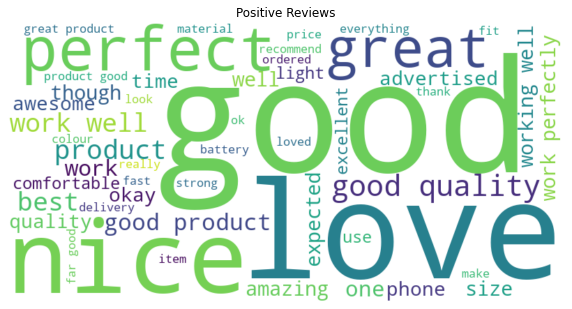

In [61]:
plot_sentiment_wordcloud(df2, sentiment="Positive")

#### *WordCount for Negative Sentiments*

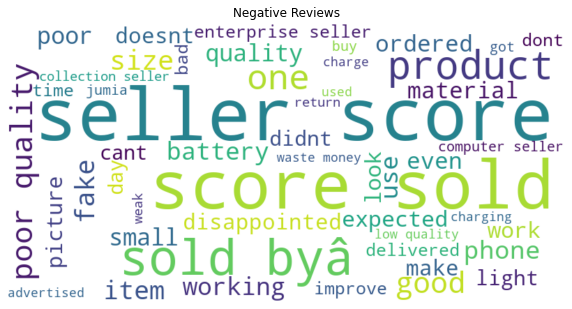

In [67]:
plot_sentiment_wordcloud(df2, sentiment="Negative")

#### *WordCount for Neutral Sentiments*

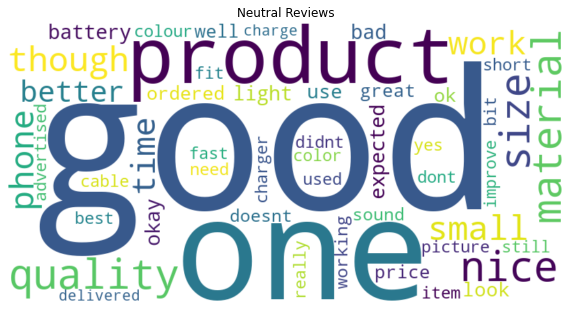

In [63]:
plot_sentiment_wordcloud(df2, sentiment="Neutral")

#### *Split the Dataset*

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(df2["cleaned_review"], 
                                                    df2["sentiment"], 
                                                    random_state = 0, 
                                                    shuffle = True, 
                                                    test_size = 0.2)

In [70]:
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=nltk.corpus.stopwords.words("english"),
    ngram_range=(1, 1)
)

In [71]:
X_train_bow = bow_counts.fit_transform(X_train)
X_test_bow = bow_counts.transform(X_test)

In [72]:
model1 = LogisticRegression(max_iter = 200)
model1.fit(X_train_bow, Y_train)
pred = model1.predict(X_test_bow)

In [74]:
print(classification_report(pred,Y_test))

              precision    recall  f1-score   support

    Negative       0.70      0.80      0.74      1436
     Neutral       0.16      0.50      0.25       231
    Positive       0.96      0.86      0.90      6253

    accuracy                           0.83      7920
   macro avg       0.61      0.72      0.63      7920
weighted avg       0.89      0.83      0.86      7920



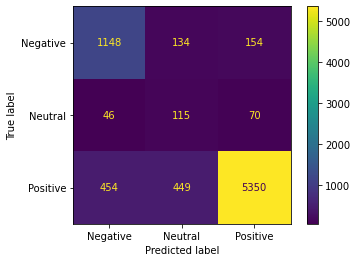

In [76]:
print(ConfusionMatrixDisplay.from_predictions(pred,Y_test));

#### *TFIDF*

In [77]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   stop_words = nltk.corpus.stopwords.words("english"))

In [78]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [79]:
model1 = LogisticRegression(max_iter = 200)
model1.fit(X_train_tfidf, Y_train)
pred = model1.predict(X_test_tfidf)

In [80]:
print(classification_report(pred,Y_test))

              precision    recall  f1-score   support

    Negative       0.69      0.80      0.74      1405
     Neutral       0.06      0.52      0.11        84
    Positive       0.97      0.84      0.90      6431

    accuracy                           0.83      7920
   macro avg       0.57      0.72      0.58      7920
weighted avg       0.91      0.83      0.86      7920



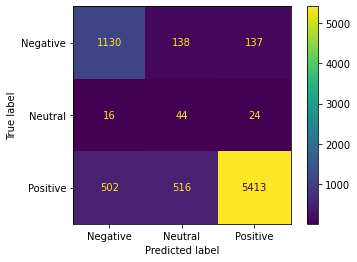

In [81]:
print(ConfusionMatrixDisplay.from_predictions(pred,Y_test))

#### *Tensorflow*

In [95]:
model = keras.Sequential(
[
    keras.Input(shape=(10120,)),
    keras.layers.Dense(256,),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32,),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation="softmax")
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               2590976   
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                8224      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [97]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'accuracy',patience = 1,verbose = 1)
early_stop = keras.callbacks.EarlyStopping(monitor = 'accuracy',patience = 5,verbose = 1,restore_best_weights = True)

In [98]:
model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"],
)

In [99]:
categories = {
    "Positive": 0,
    "Negative" : 1,
    "Neutral" : 2,
}

In [100]:
Y_train_OH = tf.one_hot(Y_train.apply(lambda x : categories[x]), 3)
Y_test_OH = tf.one_hot(Y_test.apply(lambda x : categories[x]), 3)

In [101]:
tf.config.run_functions_eagerly(True)

In [102]:
X_train_tfidf_dense = X_train_tfidf.toarray()

model.fit(
    X_train_tfidf_dense,
    Y_train_OH,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
)

Epoch 1/50
891/891 [==============================] - 43s 48ms/step - loss: 0.6857 - accuracy: 0.7478 - val_loss: 0.4544 - val_accuracy: 0.8343
Epoch 2/50
891/891 [==============================] - 38s 43ms/step - loss: 0.4448 - accuracy: 0.8450 - val_loss: 0.4467 - val_accuracy: 0.8412
Epoch 3/50
891/891 [==============================] - 40s 45ms/step - loss: 0.3947 - accuracy: 0.8647 - val_loss: 0.4589 - val_accuracy: 0.8381
Epoch 4/50
891/891 [==============================] - 40s 45ms/step - loss: 0.3701 - accuracy: 0.8744 - val_loss: 0.4618 - val_accuracy: 0.8378
Epoch 5/50
891/891 [==============================] - 41s 46ms/step - loss: 0.3611 - accuracy: 0.8786 - val_loss: 0.4616 - val_accuracy: 0.8365
Epoch 6/50
891/891 [==============================] - 43s 49ms/step - loss: 0.3505 - accuracy: 0.8830 - val_loss: 0.4677 - val_accuracy: 0.8396
Epoch 7/50
891/891 [==============================] - 42s 47ms/step - loss: 0.3399 - accuracy: 0.8879 - val_loss: 0.4725 - val_accuracy:

In [120]:
X_test_tfidf_sparse = tf.sparse.SparseTensor(
    indices=np.column_stack((X_test_tfidf.nonzero())),
    values=X_test_tfidf.data,
    dense_shape=X_test_tfidf.shape
)

# Now reorder the sparse matrix indices
X_test_tfidf_reordered = tf.sparse.reorder(X_test_tfidf_sparse)

# Make predictions using the reordered SparseTensor
predicted = model.predict(X_test_tfidf_reordered)
predicted = np.argmax(predicted, axis=1)

In [116]:
reverse_categories = {v: k for k, v in categories.items()}
pred = [reverse_categories[i] for i in predicted]
Y = [reverse_categories[i] for i in Y_test.apply(lambda x : categories[x])]

Check if both have the same length

In [117]:
print(len(pred), len(Y))

7920 7920


In [118]:
print(classification_report(pred,Y))

              precision    recall  f1-score   support

    Negative       0.69      0.77      0.72      1470
     Neutral       0.25      0.42      0.31       420
    Positive       0.94      0.86      0.90      6030

    accuracy                           0.82      7920
   macro avg       0.62      0.68      0.65      7920
weighted avg       0.85      0.82      0.84      7920



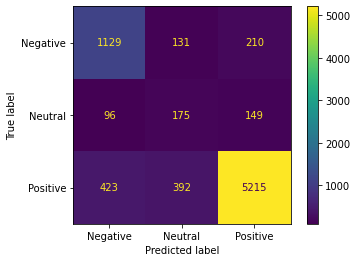

In [119]:
print(ConfusionMatrixDisplay.from_predictions(pred,Y))